In [1]:
from urllib.parse import urlparse
import re
import os
import itertools
import random
import datetime
import json

import pandas as pd
import dask.dataframe as dd
import numpy as np
from ast import literal_eval
from scipy.stats.stats import pearsonr   
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
import seaborn as sns

import community
import community as community_louvain
import networkx.algorithms.community as nx_comm
import networkx as nx

/opt/conda/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#from bs4 import BeautifulSoup
#import lxml
#from urllib.request import Request, urlopen

# Final Analysis of Telegram Data for the Bacherlor Thesis of Valentin Peter 

## Import Data and static variables

In [3]:
#Current directory
curr_dir = '/root/repos/telegraph'

# Channels with less than 10 messages
channels_less_than_10_messages = ['cbsnews', 'newsmax', 'foxnews', 'realdonaldtrump', 'msagd', 'gruene', 'nuerburgring', 'digitaler', 'potus', 'hilton', 'breitbartnews', 'yahoo', 'freiemedien', 'protonmail', 'tuckercarlson', 'posteo', 'querdenken_7141', 'maske', 'freiheitmachtwahr', 'friede_freiheit_demokratie_aut', 'danscavino', 'chrisaresoffiziell', 'archemovie', 'mike_pence', 'shomburg', 'presssec', 'querdenken_361', 'qanondeutschland', 'proudboysuncensored', 'klappstuhlfruehstueck', 'whitehouse', 'dieregierungmussweg', 'chatderfreiheit', 'klagemauer', 'corona', 'twitter', 'punkt', 'pandemie1', 'querdenken351_aktiv', 'demo_kraten', 'querdenken_831', 'thejusticedept', 'sozmi', 'querdenken_571pw', 'querdenken334', 'exfakt', 'ntd_tv', 'secpompeo', 'querdenken40_aktiv', 'polizei', 'updayde', 'gunnarkaiser', 'rosen', 'scharfschuetzenbewegung', 'impfen', 'querdenken241_aktiv', 'sidneypowell1', 'benny_johnson', 'elternstehenauf', 'soziales', 'daniel_prinz_offiziell', 'infokanalberlin', 'querdenken_40', 'querdenken831', 'querdenken_7451', 'corona_jugend_informiert', 'impfenst', 'querdenken_702', 'd_day2_0_button_verteiler_kanal', 'fakealarm', 'diebasis', 'llinwood', 'fluthilfe_portal', 'flutmanager', 'querdenken571pw_aktiv', 'steven_crowder']

# Get iterations file (Json file keeping track when data was scraped)
iterations_path = f'{curr_dir}/data_final/iterations/16-Aug-2021 (08-03-48.974626).json'
    
with open(iterations_path) as f:
    iterations = json.load(f)

# Extract all channels from the first 10 iterations
subset = {k: v for k, v in iterations.items() if k in [str(i) for i in range(11)]}

# Transform to list of channels
channels_total = [v.lower() for k, v in subset.items() for v in list(v.keys())]

# Exclude small channels
channels = [channel for channel in channels_total if channel not in channels_less_than_10_messages]

In [4]:
# Specify import types for dask df
dtype = {'channel_id' : float, 
 'channel_name' : str, 
 'forward_from' : str, 
 'forward_from_channel_id' : float,
 'forward_from_post_id' : float,
 'group_type' : str, 
 'id' : float,
 'is_reply' : bool, 
 'links': str,
 'member_count' : float,
 'mentioned_in_link': str,
 'mentions' : str,
 'participants_count' : float,
 'post_author' : str,
 'raw_text' : str,
 'reply_to_message_id' : float,
 'sender' : object,
 'sender_id' :  float,
 'title' : str,
 'views': float}

# Import dask dataframe with all attributes. (Not loaded in memory)
df_paths = ["%s/data_final/csvs/%s.csv" % (curr_dir, channel_name) for channel_name in channels]

df = dd.read_csv(df_paths, parse_dates=['datetime'], dtype=dtype, engine="python", error_bad_lines=False, blocksize=None)
df

Skipping line 580: unexpected end of data


,channel_name,channel_id,title,datetime,participants_count,raw_text,views,id,sender,post_author,is_reply,links,reply_to_message_id,group_type,member_count,forward_from,forward_from_channel_id,forward_from_post_id,mentions,sender_id,mentioned_in_link
npartitions=1979,,,,,,,,,,,,,,,,,,,,,
,object,float64,object,"datetime64[ns, UTC]",float64,object,float64,float64,object,object,bool,object,float64,object,float64,object,float64,float64,object,float64,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [5]:
# Import dataframe with subset of columns with pandas in memory (Subset creation in Notebook "Data Preprocessing")
pickle_path = f'{curr_dir}/data_final/'

frac = 1
df_pd = pd.read_pickle(f'{pickle_path}/data.pkl')
pairs = pd.read_pickle(f'{pickle_path}/pairs.pkl')
channels_df = pd.read_pickle(f'{pickle_path}/metadata.pkl')
links = pd.read_pickle(f'{pickle_path}/links.pkl').sample(frac=frac, replace=True, random_state=1)
#sample = pd.read_pickle(pickle_path + "sample.pkl")

In [6]:
# Utility functions

def get_id(name):
    return pairs[pairs.channel_name == name].channel_id.iloc[0]

def get_name(channel_id):
    return pairs[pairs.channel_id == channel_id].channel_name.iloc[0]

# 4 Results 
## 4.1 Dataset 

In [7]:
# Timespan of dataset 
min_date = df_pd.datetime.dt.date.min()
max_date = df_pd.datetime.dt.date.max()

print(f'The first messages is from {min_date} and the last from {max_date}')

The first messages is from 2015-09-21 and the last from 2021-08-16


In [8]:
# General size
print("There are %i messages from %i different channels in the dataset" % (len(df_pd), len(channels)))

There are 50777097 messages from 1979 different channels in the dataset


In [9]:
percentage_group_type = df_pd.is_group.value_counts().apply(lambda x: (x / len(df_pd)) * 100)
print(f'{percentage_group_type[True]:.2f}% of messages are in Groups and {percentage_group_type[False]:.2f}% are in channels')

77.46% of messages are in Groups and 22.54% are in channels


In [10]:
# Percentage of amount of groups and channels
channels_df.is_group.value_counts().apply(lambda x: x/len(channels_df))

False    0.770591
True     0.229409
Name: is_group, dtype: float64

In [11]:
# Highest message count in groups.
(df_pd
 .query("is_group == True")
 .groupby("channel_id")
 .size()
 .reset_index(name="count")
 .sort_values(by="count", ascending=False)
 .head(1)
 ["count"]
 .iloc[0])

1532716

In [12]:
# Median message count in groups
(df_pd
 .query("is_group == True")
 .groupby("channel_id")
 .size()
 .reset_index(name="count")
 ["count"]
 .median())

18828.0

In [13]:
# Highest message count in channels.
(df_pd
 .query("is_group == False")
 .groupby("channel_id")
 .size()
 .reset_index(name="count")
 .sort_values(by="count", ascending=False)
 .head(1)
 ["count"]
 .iloc[0])

226162

In [14]:
# Median message count in groups. 
(df_pd
 .query("is_group == False")
 .groupby("channel_id")
 .size()
 .reset_index(name="count")
 ["count"]
 .median())

2591.0

In [15]:
# Share of messages that were forwarded.
len(df_pd.forward_from.dropna()) / len(df_pd) 

0.19665139580547505

In [16]:
# Share of messages that mentioned another channel. 
len(df_pd.mentions.dropna()) / len(df_pd)

0.07387141490187987

In [17]:
number_of_messages_without_forwards = len(df_pd.query("forward_from != forward_from"))

number_of_mentions_without_forwarded_messages = len(df_pd[["channel_id", "forward_from", "mentions"]]
 .assign(msg_id=[i for i in range(len(df_pd))])
 .query("forward_from != forward_from")
 .reset_index()
 .dropna(subset=["mentions"])
 .assign(mentions= lambda x: x.mentions.apply(literal_eval))
 .explode(column="mentions")
 .merge(pairs)
 .query("channel_name != mentions")
 .drop_duplicates(subset=["msg_id"]))

# Fraction of all messages that contained a mention. (Without self mentions, without forwarded messages)
number_of_mentions_without_forwarded_messages / number_of_messages_without_forwards

0.019946234173561245

## 4.2 Communities in the Telegram Network

The community detection algorithm was already used in the Data Preprocessing Notebook in order to have the community available as metadata for further analysis.

In [18]:
# Amount of communities
len(channels_df.community.unique())

30

In [19]:
# Find top communities for further analysis
def get_top_channels_per_community(n, community):
    df = channels_df[channels_df.community == community].sort_values(by="rank", ascending=False).head(n)
    return ", ".join(list(df.channel_name))

# Communitys containing minimum 1% of the top nodes
top_communities = (channels_df[["community", "is_group"]]
 .groupby("community")
 .count()
 .rename(columns={"is_group": "count"})
 .sort_values(by="count", ascending=False)
 .assign(node_share=lambda x: [(count / len(channels_df)) for count in x["count"]])
 .assign(top_channels = lambda x: [get_top_channels_per_community(5, community) for community in x.index])
 .query("node_share > 0.01"))

top_communities
# top_communities.to_latex()

,count,node_share,top_channels
community,,,
3.0,971,0.490652,"reitschusterde, evahermanoffiziell, schubertsl..."
1.0,354,0.178878,"epochtimesde, ntddeutsch, qlobalchange, qparad..."
0.0,348,0.175846,"jamesokeefeiii, project_veritas, breaking911, ..."
2.0,106,0.053562,"neueerde_technologie_verjuengung, gaiadeutsch,..."
8.0,38,0.019202,"jackdawkins, britainfirst, bellumactanews, mil..."
6.0,32,0.016170,"adrenocrime, dokukiste, outdoor_germany, augen..."
11.0,24,0.012127,"blaupausetv, riesen_tartaria, vereinigtewahrhe..."


In [20]:
# Share of top communities of all channels. 
channels_df.community.value_counts().head(7).sum() / len(channels_df)

0.9464375947448206

In [21]:
# Language distribution
channels_df.language.value_counts()

de    1549
en     407
fa       3
ru       3
nl       2
ht       2
es       1
ar       1
pt       1
fr       1
el       1
iw       1
Name: language, dtype: int64

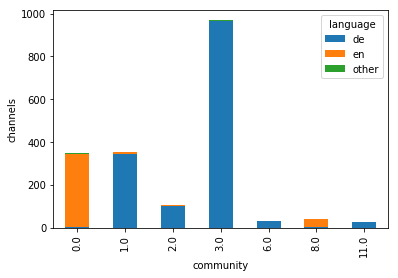

In [22]:
# Language share per communtiy. 
communities = list(channels_df.community.value_counts().head(7).index)

community_language = (channels_df[["community", "language"]]
 .query('community in [3.0, 1.0, 0.0, 2.0, 8.0, 6.0, 11.0]')
 .groupby(["community", "language"])
 .size()
 .reset_index(name="counts")
 .pivot(index='community', columns='language', values="counts")
 .fillna(0)
 .assign(other=lambda x: x['ru']+x['el']+x['es']+x['fr']+x['ht'])
 [["de", "en", "other"]])
 #.apply(lambda x: x/x.sum(), axis=1))

community_language.plot.bar(stacked=True, ylabel="channels")

plt.savefig(f'{curr_dir}/data_final/graphics/community_language.eps', format='eps', bbox_inches='tight')

In [23]:
def summarize_channel(channel_name):
    channel_id = get_id(channel_name)
    df = df_pd.query(f'channel_id == {channel_id}')
    
    information = {
        "msg_count" : len(df), 
        "participants_count" : df.tail(1).participants_count.iloc[0],
        "participants_count_rank": (channels_df.query('language == "de"').sort_values(by="participants_count", ascending=False).reset_index().query("channel_name == @channel_name").index[0] + 1),
        "pagerank" : channels_df.query('channel_name == @channel_name')["rank"].iloc[0],
        "first_message": str(df.datetime.dt.date.min()),
        "views" : {
            "min": df.views.min(),
            "avg": df.views.mean(),
            "max": df.views.max()
        },
        "most_forwarded": list(df.forward_from.where(df.forward_from != {channel_name}).value_counts().head(5).index),
        "was_most_forwarded_in": list(df_pd.query(f'forward_from == @channel_name').merge(channels_df).channel_name.value_counts().head(5).index)
    }
    
    
    return information

In [24]:
summarize_channel("reitschusterde")

{'msg_count': 2462,
 'participants_count': 181046.0,
 'participants_count_rank': 3,
 'pagerank': 0.028319642614206296,
 'first_message': '2020-04-04',
 'views': {'min': 290.0, 'avg': 93653.3298088654, 'max': 489476.0},
 'most_forwarded': ['reitschusterde'],
 'was_most_forwarded_in': ['oli_redet',
  'reitschusterdechat',
  'donald_j_trump_q_family_germany',
  'tayssen',
  'impfkritisch']}

## 4.3 Sampling

In [25]:
#  Map every channel to the iteration when it was scraped
iterations_df = pd.DataFrame([[k, channel]
                        for k,v in iterations.items() 
                        for channel, count in v.items()], columns=["iteration", "channel_name"])

iterations_df.head(2)

,iteration,channel_name
0,0,fakepandemie
1,0,querdenken7451


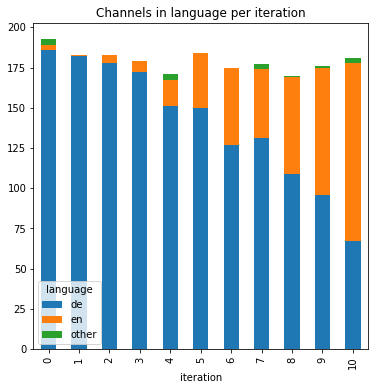

In [26]:
# Amount of channels with a certain languages per iteration.

language_iteration = (iterations_df
                     .merge(channels_df)[["iteration", "language", "channel_name"]]
                     .groupby(["iteration", "language"])
                     .count()
                     .rename(columns={"channel_name":"count"})
                     .reset_index()
                     .pivot(index='iteration', columns='language', values='count')
                     .fillna(0)
                     .assign(other=lambda x: x['ru']+x['fa']+x['nl']+x['ht']+x['pt']+x['ar']+ x['fr']+x['iw']+x['el']+x['es']) 
                     [["de", "en", "other"]])


language_iteration.index = language_iteration.index.astype(int)
language_iteration = language_iteration.sort_index()

fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(6,6))
language_iteration.plot.bar(ax=axes, stacked=True, title="Channels in language per iteration")

plt.savefig(f'{curr_dir}/data_final/graphics/iteration_evaluation_channel_count.eps', format="eps")

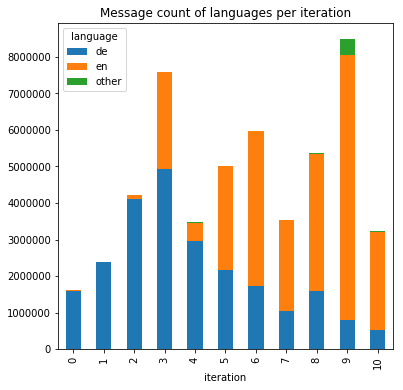

In [27]:
# Amount of messages evaluated with a certain languages per iteration.
channel_counts = (pd.DataFrame(df_pd[["channel_id"]].value_counts())
                  .reset_index()
                  .merge(pairs)
                  .rename(columns={0:"count"})
                  [["channel_name", "count"]])

language_iteration_msg_count = (iterations_df
                        .merge(channels_df)
                        .merge(channel_counts)
                        [["iteration", "language", "count"]]
                        .groupby(["iteration", "language"])
                        .sum()
                        .reset_index()
                        .pivot(index='iteration', columns='language', values='count')
                        .fillna(0)
                        .assign(other=lambda x: x['ru']+x['fa']+x['nl']+x['ht']+x['pt']+x['ar']+ x['fr']+x['iw']+x['el']+x['es'])
    [["de", "en", "other"]])

language_iteration_msg_count.index = language_iteration_msg_count.index.astype(int)
language_iteration_msg_count = language_iteration_msg_count.sort_index()

fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(6,6))
language_iteration_msg_count.plot.bar(ax = axes, stacked=True, title="Message count of languages per iteration")

plt.savefig(f'{curr_dir}/data_final/graphics/iteration_evaluation_msg_count.eps', format="eps")

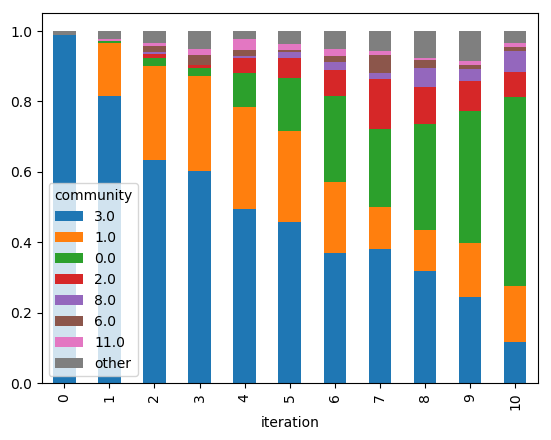

In [28]:
# Community drift per iteration. 
community_iteration = (pd.DataFrame([[k, channel]
                                    for k,v in iterations.items() 
                                    for channel, count in v.items()], columns=["iteration", "channel_name"])
                     .merge(channels_df)[["iteration", "community", "channel_name"]]
                     .groupby(["iteration", "community"])
                     .count()
                     .rename(columns={"channel_name":"count"})
                     .reset_index()
                     .pivot(index='iteration', columns='community', values='count')
                     .fillna(0)
                     .assign(other=lambda x: x[10.0]+x[16.0]+x[21.0]+x[15.0]+x[12.0]+x[14.0]+x[18.0]+x[19.0]+x[24.0]+x[5.0]+x[27.0]+x[22.0]+x[20.0]+x[13.0]+x[17.0]+x[9.0]+x[7.0]+x[26.0]+x[23.0]+x[28.0]+x[25.0]+x[4.0])
                     [[3.0,1.0,0.0,2.0,8.0,6.0,11.0, "other"]]
                       .apply(lambda x: x/x.sum(), axis=1))


community_iteration.index = community_iteration.index.astype(int)
community_iteration = community_iteration.sort_index()
plt.style.use('default')
community_iteration.plot.bar(stacked=True)
plt.savefig(f'{curr_dir}/data_final/graphics/iteration_community.eps', format="eps")

## 4.4 Ranking influential channels 

In [29]:
# Calcuclate edges and weights on forward graph
edges_df = (df_pd
            .loc[:, ["channel_id", "forward_from"]]
            .groupby(by=["channel_id", "forward_from"])
            .size()
            .reset_index(name="count")
            .merge(pairs, left_on="channel_id", right_on="channel_id")
            .drop(columns=["channel_id"])
            .reindex(columns=["channel_name", "forward_from", "count"]))


# Df to tuples.
edges_tuple = [tuple(x) for x in edges_df.to_numpy()]

# Only core network (channels that have been scraped)
edges_tuple_only_scraped = [ele for ele in edges_tuple if ele[0] in channels and ele[1] in channels]

# Create networkx graph
G = nx.DiGraph()
G.add_weighted_edges_from(edges_tuple_only_scraped)

# Rank by pagerank Calculate pagerank
pagerank_dict = nx.pagerank(G)
pagerank = pd.DataFrame.from_dict(pagerank_dict, orient='index', columns=["rank"]).sort_values(by="rank", ascending=False)

In [30]:
# Calcuclate edges and weights on mention graph
edges_df_mention = (df_pd[["channel_id", "forward_from", "mentions"]]
             .dropna(subset=["mentions"])
             .assign(mentions= lambda x: x.mentions.apply(literal_eval))
             .explode(column="mentions")
             .merge(pairs)
             .query("channel_name != mentions")
             .groupby(by=["channel_name", "mentions"])
             .size()
             .reset_index(name="count"))


edges_tuple_mention = [tuple(x) for x in edges_df_mention.to_numpy()]

# Only core network (channels that have been scraped)
edges_tuple_only_scraped_mention = [ele for ele in edges_tuple_mention if ele[0] in channels and ele[1] in channels]

# Create networkx graph
G_mention = nx.DiGraph()
G_mention.add_weighted_edges_from(edges_tuple_only_scraped_mention)

# Calculate pagerank
pagerank_dict_mention = nx.pagerank(G_mention)
pagerank_mention = (pd.DataFrame.from_dict(pagerank_dict_mention, orient='index', columns=["rank"])
                .sort_values(by="rank", ascending=False)
                .reset_index()
                .rename(columns={"index": "channel_name", "rank": "pagerank_mention"}))

In [31]:
merged = (pagerank
          .reset_index()
          .rename(columns={"index": "channel_name", "rank" : "pagerank"})
          .merge(channels_df[["channel_name", "participants_count"]], how="inner", on="channel_name")
          .merge(pagerank_mention, how="inner", left_on="channel_name", right_on="channel_name"))

In [32]:
merged_meta = (merged
               .merge(channels_df)
               .merge(iterations_df)
               [["channel_name", "pagerank", "participants_count", "pagerank_mention", "language", "iteration", "is_group"]]
               .assign(iteration = lambda x: x.iteration.astype(int)))

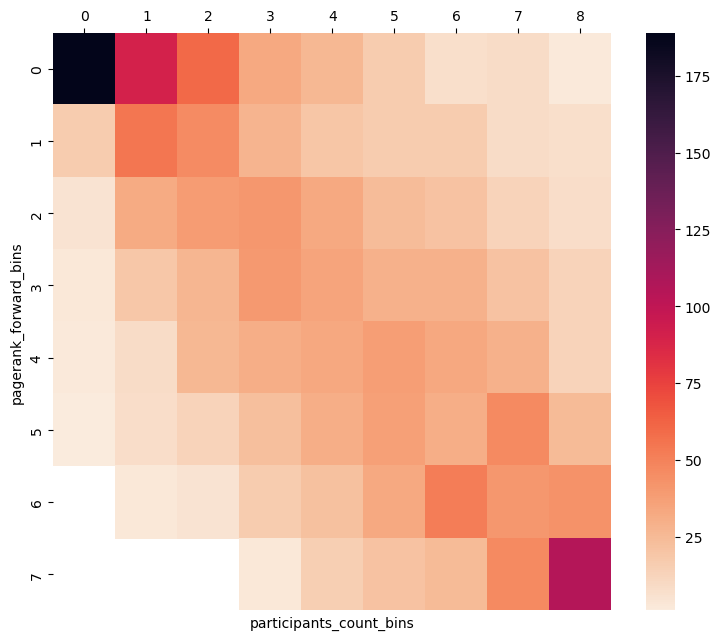

In [33]:
# Correlation between the forward-PageRank and participants count per channel.
fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(9, 7.5))

# Declare Data
merged_2 = merged_meta[["participants_count", "pagerank"]]

# Number of bins
nbins=9

# Bin data and count 
cuts = pd.DataFrame({"participants_count_bins" : pd.qcut(merged_2.participants_count, nbins, duplicates='drop', labels=False), "pagerank_forward_bins" : pd.qcut(merged_2.pagerank, nbins, duplicates='drop', labels=False)})
counts = merged_2.join(cuts)[["pagerank_forward_bins", "participants_count_bins"]].groupby(list(cuts)).size().unstack(level = 0)

#Plot binned data
fig = sns.heatmap(counts.replace(0, np.nan),
            #norm=LogNorm(), 
            cmap=sns.cm.rocket_r)

# Move ticks to top
fig.xaxis.tick_top()


plt.savefig(f'{curr_dir}/data_final/graphics/pagerank_forward_heatmap.eps', format='eps', bbox_inches='tight')

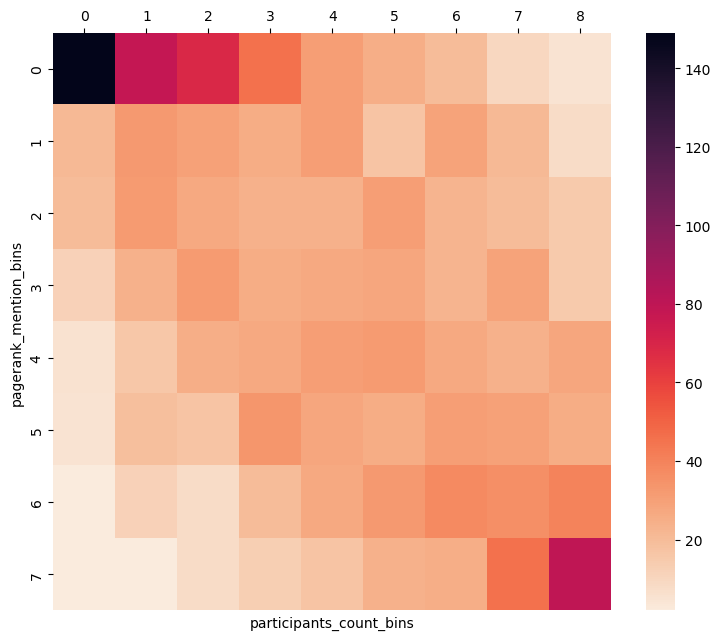

In [34]:
# Correlation between the mention-PageRank and participants count per channel.
fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(9, 7.5))

# Declare Data
merged_2 = merged[["participants_count", "pagerank_mention"]]


# Bin data and count 
cuts = pd.DataFrame({"participants_count_bins" : pd.qcut(merged_2.participants_count, nbins, duplicates='drop', labels=False), "pagerank_mention_bins" : pd.qcut(merged_2.pagerank_mention, nbins, duplicates='drop', labels=False)})
counts = merged_2.join(cuts)[["pagerank_mention_bins", "participants_count_bins"]].groupby(list(cuts)).size().unstack(level = 0)

#Plot binned data
fig = sns.heatmap(counts.replace(0, np.nan),
            #norm=LogNorm(),
            cmap=sns.cm.rocket_r)

# Move ticks to top
fig.xaxis.tick_top()

plt.savefig(f'{curr_dir}/data_final/graphics/pagerank_mention_heatmap.eps', format='eps', bbox_inches='tight')

In [35]:
# With pagerank computed on whole network 
correlation_participants_count_x = (merged_meta[merged_meta.language == "de"].corr()[["participants_count"]].rename(columns={"participants_count": "german_channels"})
 .assign(english_channels=merged_meta[merged_meta.language == "en"].corr()[["participants_count"]])
 .assign(all_channels=merged.corr()[["participants_count"]])
 .round(2)
 .iloc[[0,2], :])


print(correlation_participants_count_x.to_latex())
#correlation_participants_count_x

\begin{tabular}{lrrr}
\toprule
{} &  german\_channels &  english\_channels &  all\_channels \\
\midrule
pagerank         &             0.55 &              0.12 &          0.13 \\
pagerank\_mention &             0.42 &              0.24 &          0.20 \\
\bottomrule
\end{tabular}



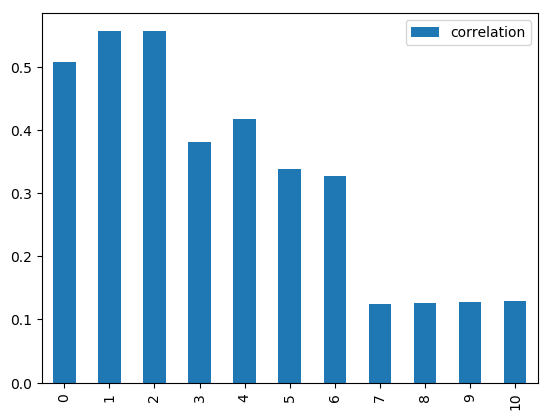

In [36]:
# Correlation per iteration (not used in thesis, only for understanding)
iteration = [i for i in range(11)]
correlation = [merged_meta.query("iteration <= @i")[["pagerank", "participants_count"]].corr().iloc[0, 1] for i in range(11)]

pd.DataFrame()
pd.DataFrame(correlation, index =iteration, columns =['correlation']).plot.bar()

### 4.4.2. Influential Channels 

In [37]:
# Top channels by pagerank on forward graph. 
top_channels = (channels_df
 .query("language =='de'")
 .sort_values(by="rank", ascending=False)
 .head(10)
 .assign(rank= lambda x: x["rank"].round(4))
 [["channel_name", "rank", "community", "category_content", "category_type", "participants_count"]])

#print(top_channels.set_index("channel_name").to_latex())
top_channels

,channel_name,rank,community,category_content,category_type,participants_count
185,reitschusterde,0.0283,3.0,covid_sceptic,media,166449.0
292,epochtimesde,0.0140,1.0,alternative,media,45498.0
983,ntddeutsch,0.0114,1.0,alternative,media,11762.0
165,evahermanoffiziell,0.0109,3.0,conspiracy,influencer,183440.0
322,schubertslm,0.0107,3.0,other,news_aggregator,47207.0
71,oliverjanich,0.0107,3.0,conspiracy,influencer,163485.0
284,nachrichtenportal,0.0098,3.0,covid_sceptic,news_aggregator,34016.0
271,qlobalchange,0.0097,1.0,q-anon,news_aggregator,157989.0
243,qparadise,0.0082,1.0,q-anon,news_aggregator,43548.0
209,attilahildmann,0.0078,3.0,conspiracy,influencer,111150.0


In [38]:
# Top channels by participants count. 
(channels_df
 .query("language =='de'")
 .sort_values(by="participants_count", ascending=False)
 .head(5)
 .assign(rank= lambda x: x["rank"].round(4))
 [["channel_name", "rank", "community", "category_content", "category_type", "participants_count"]]
 .reset_index())

,index,channel_name,rank,community,category_content,category_type,participants_count
0,140,corona_infokanal_bmg,0.0001,3.0,NaN,NaN,400544.0
1,165,evahermanoffiziell,0.0109,3.0,conspiracy,influencer,183440.0
2,185,reitschusterde,0.0283,3.0,covid_sceptic,media,166449.0
3,71,oliverjanich,0.0107,3.0,conspiracy,influencer,163485.0
4,48,michaelwendlerofficial,0.0008,3.0,NaN,NaN,159572.0


In [39]:
# Most shared domains in schubertslm
schubertslm_id = get_id("schubertslm")
(links
 .query("channel_id == @schubertslm_id")
 .groupby("domain")
 .size()
 .reset_index(name="counts")
 .sort_values(by="counts", ascending=False)
 .head(6))

,domain,counts
108,t.me,15148
20,c.kopp-verlag.de,6466
434,www.welt.de,1982
416,www.tichyseinblick.de,1579
386,www.spiegel.de,1172
219,www.faz.net,1117


## 4.5 Growth of the network 

### 4.5.1 Stringency Index

In [40]:
# Import covid stringency index 
stringency = pd.read_csv(f'{curr_dir}/external-data/covid-stringency-index.csv', parse_dates=["Day"])

stringency_germany = stringency.query("Entity == 'Germany'")

german_channels = list(channels_df.query("language == 'de'").channel_id)

german_channel_mask = df_pd.channel_id.isin(german_channels)

### 4.5.2 Message Frequency

In [41]:
msgs_and_stringency_evolution = (df_pd[df_pd.channel_id.isin(german_channels)]
         .assign(date=lambda x: pd.to_datetime(x['datetime'].dt.date))
         .groupby("date")
         .size()
         .reset_index(name="msgs_per_day")
         .merge(stringency_germany[["Day", "stringency_index"]], left_on="date", right_on="Day", how="inner")
         .assign(msgs_1000_per_day = lambda x: x.msgs_per_day / 1000)
         .drop(["date", "msgs_per_day"], axis=1)
         .set_index("Day"))

print(f'Timespan of data further used from {msgs_and_stringency_evolution.index.min().strftime("%Y-%m-%d")} until {msgs_and_stringency_evolution.index.max().strftime("%Y-%m-%d")}')

Timespan of data further used from 2020-01-21 until 2021-08-16


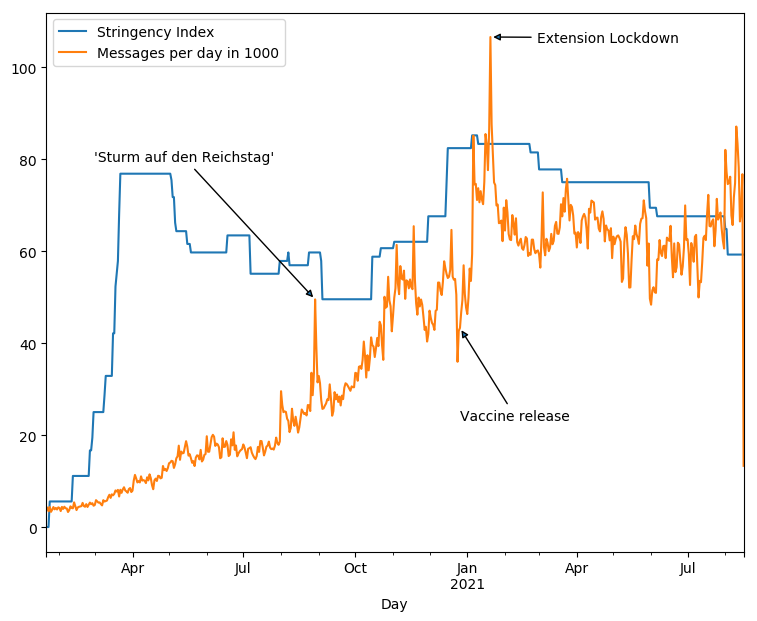

In [42]:
# Evolution of messages plotted against the Stringency Index of Germany
ax = (msgs_and_stringency_evolution
      .rename(columns={"stringency_index": "Stringency Index", "msgs_1000_per_day": "Messages per day in 1000"})
      .plot(figsize=(9,7)))

plt.legend(loc='upper left')

vaccine_release = '2020-12-26'
vaccine_release_msg_count = msgs_and_stringency_evolution.query("Day == @vaccine_release").msgs_1000_per_day[0]

reichstag=  "2020-08-29"
reichstag_msg_count = msgs_and_stringency_evolution.query("Day == @reichstag").msgs_1000_per_day[0]

verlängerung_lockdown=  "2021-01-20"
verlängerung_lockdown_msg_count = msgs_and_stringency_evolution.query("Day == @verlängerung_lockdown").msgs_1000_per_day[0]

try:
    ax.annotate("Vaccine release", 
                xy=(vaccine_release, vaccine_release_msg_count), 
                xytext=(vaccine_release,vaccine_release_msg_count - 20), 
                arrowprops=dict(arrowstyle='-|>'))
    ax.annotate("'Sturm auf den Reichstag'", 
                xy=(reichstag, reichstag_msg_count), 
                xytext=("2020-02-29", reichstag_msg_count + 30), 
                arrowprops=dict(arrowstyle='-|>'))
    
    ax.annotate("Extension Lockdown", 
                xy=(verlängerung_lockdown, verlängerung_lockdown_msg_count), 
                xytext=("2021-02-27", verlängerung_lockdown_msg_count - 1), 
                arrowprops=dict(arrowstyle='-|>'))
    
except TypeError:
    pass


plt.savefig(f'{curr_dir}/data_final/graphics/correlation_covid_mesaures.eps', format='eps', bbox_inches='tight')   

### 4.5.3  Network Growth

In [43]:
# New edges per Week
new_edges = (df_pd[df_pd.channel_id.isin(german_channels)]
     .dropna(subset = ['forward_from'])
     .assign(date=lambda x: pd.to_datetime(x['datetime'].dt.date))
     .groupby("date")
     .size())

stringency_edges = (new_edges
     .reset_index(name="edge_count")
     .merge(stringency_germany.rename(columns={"Day": "date"})[["date", "stringency_index"]])
     .assign(edge_count= lambda x: x.edge_count / 1000)
     .set_index("date"))

# New Source Nodes by Date 
nodes_first_occurence = (df_pd[df_pd.channel_id.isin(german_channels)]
             .sort_values("datetime")
             .groupby("channel_id", as_index=False)
             .first())

new_nodes =  (nodes_first_occurence[nodes_first_occurence["datetime"] > "2020-02"]
             .assign(week=lambda x: pd.to_datetime(x['datetime'].dt.strftime('%Y-%m')))
             [["channel_id", "week"]]
             .groupby("week")
             .size())

new_nodes_date_spread = (new_nodes
                         .reset_index(name="node_count")
                         .rename(columns={"week": "date"})
                         .set_index("date")
                         .head(-1)
                         .resample('d')
                         .ffill()
                         .reset_index())

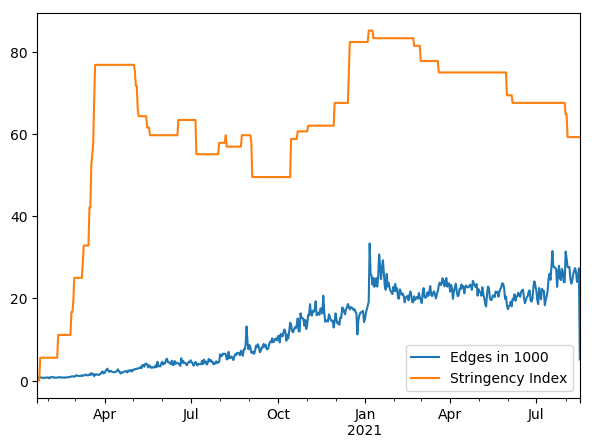

In [44]:
# Evolution of the number of edges per day plotted against the Stringency Index of Germany
(stringency_edges
 .rename(columns={"stringency_index": "Stringency Index", "edge_count": "Edges in 1000"})
 .plot(xlabel="", figsize=(7,5)))

plt.savefig(f'{curr_dir}/data_final/graphics/network_evolution_edges.eps', format='eps', bbox_inches='tight') 

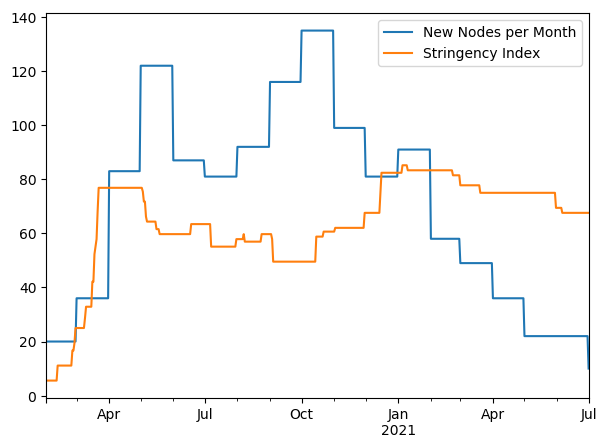

In [45]:
# Evolution of the number of new nodes plotted against the Stringency Index of Germany
(new_nodes_date_spread
 .merge(stringency_germany.rename(columns={"Day": "date"})[["date", "stringency_index"]])
 .set_index("date")
 .rename(columns={"node_count": "New Nodes per Month", "stringency_index": "Stringency Index"})
 .plot(xlabel="", figsize=(7,5)))

plt.savefig(f'{curr_dir}/data_final/graphics/network_evolution_nodes.eps', format='eps', bbox_inches='tight')  

In [46]:
# Correlation coefficient between stringency and network statistics.
(msgs_and_stringency_evolution
 .reset_index()
 .rename(columns={"Day": "date"})
 .merge(stringency_edges.reset_index())
 .assign(edge_count=lambda x: x.edge_count * 1000)
 .corr())

,stringency_index,msgs_1000_per_day,edge_count
stringency_index,1.000000,0.619526,0.588004
msgs_1000_per_day,0.619526,1.000000,0.989027
edge_count,0.588004,0.989027,1.000000


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


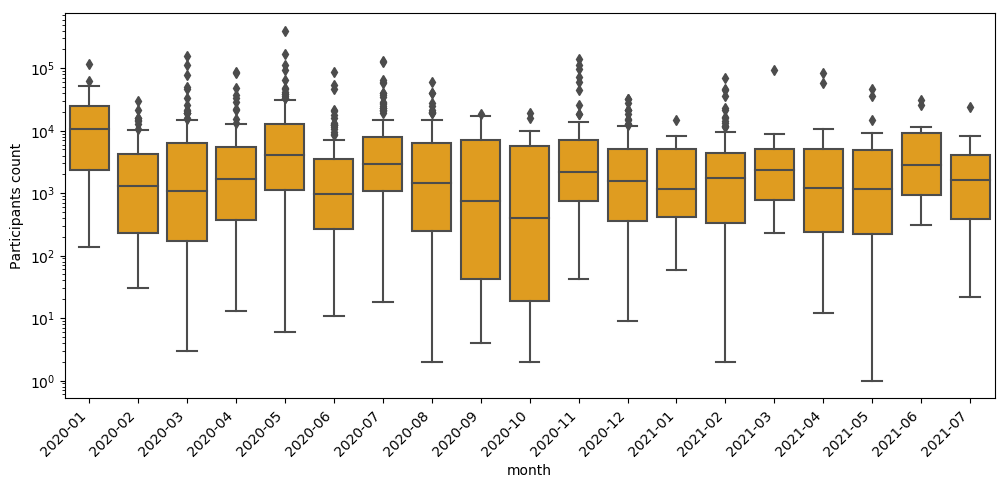

In [47]:
# Boxplot of the current channel size of channels created during different stages of the COVID-19 Pandemic.
participants_month = (nodes_first_occurence.set_index("datetime").loc["2020-01-01":"2021-08-01"].reset_index()[["channel_id", "datetime"]]
 .merge(channels_df[["participants_count", "channel_id", "channel_name", "category_content"]])
 .assign(month=lambda x: pd.to_datetime(x.datetime.dt.strftime('%Y-%m')))
 [["month", "participants_count"]]
 .rename(columns={"participants_count": "Participants count"}))


fig, ax = plt.subplots(figsize=(12,5))
ax.set(yscale="log")
sns.boxplot(participants_month.month, participants_month["Participants count"], ax=ax, color="orange")
x_dates = participants_month['month'].dt.strftime('%Y-%m').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

plt.savefig(f'{curr_dir}/data_final/graphics/distribution_participants_per_month.eps', format='eps', bbox_inches='tight')

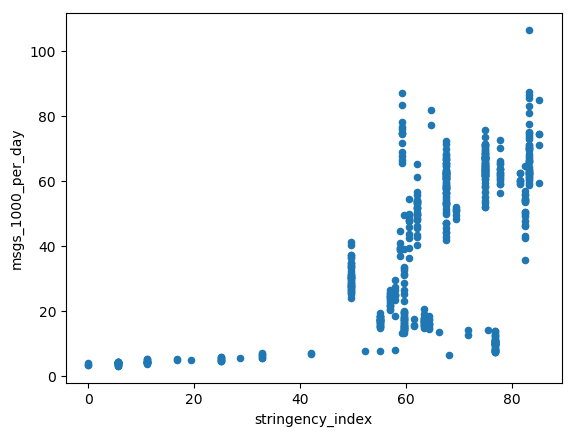

In [48]:
# Scatter plot between message frequency and stringency index
(msgs_and_stringency_evolution
 .reset_index()
 .rename(columns={"Day": "date"})
 .merge(stringency_edges.reset_index())
[["stringency_index", "msgs_1000_per_day"]]).plot.scatter(x="stringency_index", y="msgs_1000_per_day")

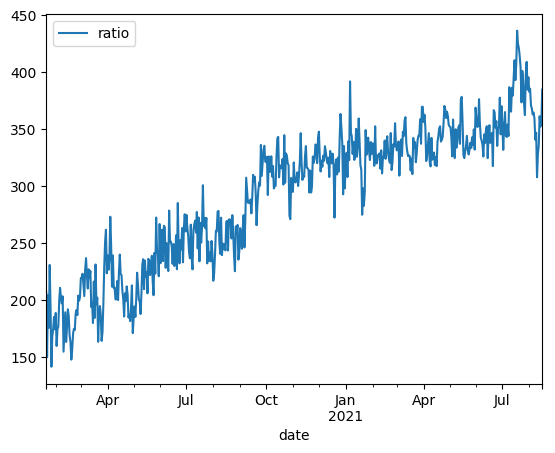

In [49]:
# Ratio of edge_count to message frequency
(msgs_and_stringency_evolution
 .reset_index()
 .rename(columns={"Day": "date"})
 .merge(stringency_edges.reset_index())
 .assign(ratio=lambda x: (x.edge_count * 1000) / x.msgs_1000_per_day)
 .set_index("date")[["ratio"]]
 .plot())

### 4.5.4  Community evolution

In [50]:
def get_top_3_communities_by_cutoff_date(date):
    """
    Return a summary of the network at the current state defined via the varibal date.

    :param date: cutoff date according to which the df is subsetted. 
    :type date: str in form of Y-m-d 
    """
    edges_df = (df_pd
                .set_index("datetime")
                .loc[:date]
                .reset_index()
                [["channel_id", "forward_from", "participants_count"]]
                .groupby(by=["channel_id", "forward_from"])
                .count()
                .reset_index()
                .merge(pairs, left_on="channel_id", right_on="channel_id")
                .drop(columns=["channel_id"])
                .reindex(columns=["channel_name", "forward_from", "participants_count"]))
                

    edges_tuple = [tuple(x) for x in edges_df.to_numpy()]

    # Only core network (channels that have been scraped)
    edges_tuple_only_scraped = [ele for ele in edges_tuple if ele[0] in channels and ele[1] in channels]

    # Only core network (channels that have been scraped)
    #edges_tuple_only_scraped = [ele for ele in edges_tuple if ele[0] in channels and ele[1] in channels]

    # Create networkx graph
    G = nx.DiGraph()
    G.add_weighted_edges_from(edges_tuple_only_scraped)

    # Undirected Graph for community detection
    G_und = G.to_undirected()

    # Compute partition
    partition = community.best_partition(G_und, random_state=1)

    # Save communities
    community_df = pd.DataFrame(partition.items(), columns=["channel_name", "community"])
    
    pagerank_dict = nx.pagerank(G)
    pagerank = pd.DataFrame.from_dict(pagerank_dict, orient='index', columns=["rank"]).sort_values(by="rank", ascending=False).reset_index().rename(columns={"index": "channel_name"})

    c = community_df.merge(channels_df[["channel_name", "category_content"]]).merge(pagerank)

    # Communitys containing minimum 1% of the top nodes
    top_communities = (c
     .groupby("community")
     .size()
     .reset_index(name="count")
     .sort_values(by="count", ascending=False)
     .assign(node_share=lambda x: [(count / len(c)) for count in x["count"]])
     .head(4)
     .assign(top_channels = lambda x: [list(c
                                            .sort_values(by="rank", ascending=False)
                                            .query("community == @community")
                                            .head(7)
                                            .channel_name) for community in x.index])
     .assign(categories=lambda x: [list(c.query("community == @community")
                                            .groupby("category_content")
                                            .size()
                                            .sort_values(ascending=False)
                                            .head(1)
                                            .index)[0] for community in x.index]))
    
    print(f'Network until: {quarters[0]}')
    print(f'Number of channels: {len(c)}, Number of communities:  {len(c.community.unique())}')
    print(f'Top channels: {list(pagerank.head(20).channel_name)}')
    
    # Compute clustering coeeficient
    clustering_coefficient = nx.average_clustering(G.to_undirected())
    
    print(f'Average clustering: {clustering_coefficient}')
    
    return top_communities

In [51]:
# List of the 7 quarters analysed
quarters = ["2020-03-31", "2020-06-30", "2020-09-30", "2020-12-31", "2021-03-31", "2021-06-30", "2021-09-30"]

In [52]:
# In the following a network snapshot for each quarter is presented
pd.set_option('display.max_colwidth', None)

In [53]:
get_top_3_communities_by_cutoff_date(quarters[0])

Network until: 2020-03-31
Number of channels: 384, Number of communities:  17
Top channels: ['oliverjanich', 'jackdawkins', 'britainfirst', 'unzensiert', 'dokukiste', 'lutzbachmann', 'kulturstudio', 'ein_prozent', 'info_direkt', 'outdoor_germany', 'qlobalchange', 'evahermanoffiziell', 'gesundheitsecke', 'siegfrieddaebritz', 'bellumactanews', 'martinsellnerib', 'tommyrobinsonnews', 'expresszeitung', 'jouwatch', 'compactmagazin']
Average clustering: 0.46986610926596367


,community,count,node_share,top_channels,categories
8,8,67,0.174479,"[qlobalchange, connectivevents, buergerinformative, bitchbotboiilive, taufertshoefer, qlobalchangeusa, charliekirk]",q-anon
6,6,65,0.169271,"[unzensiert, ein_prozent, pmberichte, insvenswelt, videodump1, wim4u, klemenskilictelegram]",conspiracy
15,15,60,0.156250,"[dokukiste, outdoor_germany, gesundheitsecke, blaupausetv, rubikonnews, buecherkiste, bewussttv]",covid_sceptic
11,11,59,0.153646,"[oliverjanich, kulturstudio, evahermanoffiziell, martinsellnerib, expresszeitung, jouwatch, compactmagazin]",conspiracy


In [54]:
get_top_3_communities_by_cutoff_date(quarters[1])

Network until: 2020-03-31
Number of channels: 685, Number of communities:  24
Top channels: ['oliverjanich', 'attilahildmann', 'qlobalchange', 'evahermanoffiziell', 'jackdawkins', 'unzensiert', 'britainfirst', 'dokukiste', 'kulturstudio', 'expresszeitung', 'dawidsnowden', 'martinsellnerib', 'gesundheitsecke', 'bellumactanews', 'kenjebsen', 'lutzbachmann', 'nachrichtenportal', 'info_direkt', 'outdoor_germany', 'ein_prozent']
Average clustering: 0.4442455086549024


,community,count,node_share,top_channels,categories
4,4,152,0.221898,"[qlobalchange, kenjebsen, qparadise, bitchbotboiilive, freeyourmindkanal, qlobalchangeusa, into_the_light_news]",q-anon
1,1,150,0.218978,"[oliverjanich, evahermanoffiziell, kulturstudio, expresszeitung, martinsellnerib, gesundheitsecke, nachrichtenportal]",querdenker
11,11,63,0.091971,"[attilahildmann, querdenken_711, xavier_naidoo, rufdertrommeln, querdenken_713_info, demostream, querdenken_615]",querdenker
0,0,55,0.080292,"[jackdawkins, britainfirst, bellumactanews, tommyrobinsonnews, realvincentjames, galliadaily, miloofficial]",far_right


In [55]:
get_top_3_communities_by_cutoff_date(quarters[2])

Network until: 2020-03-31
Number of channels: 1003, Number of communities:  24
Top channels: ['oliverjanich', 'attilahildmann', 'evahermanoffiziell', 'qlobalchange', 'martinlejeune', 'unzensiert', 'jackdawkins', 'nachrichtenportal', 'dokukiste', 'britainfirst', 'kulturstudio', 'qparadise', 'expresszeitung', 'querdenken_711', 'martinsellnerib', 'bellumactanews', 'gesundheitsecke', 'kenjebsen', 'lutzbachmann', 'tommyrobinsonnews']
Average clustering: 0.4428515662083871


,community,count,node_share,top_channels,categories
6,6,224,0.223330,"[oliverjanich, evahermanoffiziell, unzensiert, nachrichtenportal, kulturstudio, expresszeitung, martinsellnerib]",querdenker
8,8,215,0.214357,"[martinlejeune, querdenken_711, haintz, samueleckert, corona_ausschuss, bitteltv, klagepaten_eu]",querdenker
3,3,188,0.187438,"[qlobalchange, qparadise, bitchbotboiilive, fufmedia, q_d_r_a, into_the_light_news, q_faktor_germany]",q-anon
0,0,74,0.073779,"[jackdawkins, britainfirst, bellumactanews, lutzbachmann, tommyrobinsonnews, info_direkt, ein_prozent]",far_right


In [56]:
get_top_3_communities_by_cutoff_date(quarters[3])

Network until: 2020-03-31
Number of channels: 1382, Number of communities:  22
Top channels: ['epochtimesde', 'oliverjanich', 'attilahildmann', 'qlobalchange', 'nachrichtenportal', 'evahermanoffiziell', 'reitschusterde', 'leas_einblick', 'corona_ausschuss', 'qparadise', 'haintz', 'ntddeutsch', 'jackdawkins', 'unzensiert', 'britainfirst', 'kulturstudio', 'dokukiste', 'kenjebsen', 'expresszeitung', 'translatedpressde']
Average clustering: 0.44751006762416723


,community,count,node_share,top_channels,categories
8,8,511,0.369754,"[attilahildmann, nachrichtenportal, reitschusterde, corona_ausschuss, haintz, kenjebsen, faktenfriedenfreiheit]",querdenker
1,1,229,0.165702,"[epochtimesde, qlobalchange, leas_einblick, qparadise, ntddeutsch, translatedpressde, q_d_r_a]",q-anon
7,7,208,0.150507,"[oliverjanich, evahermanoffiziell, jackdawkins, unzensiert, britainfirst, kulturstudio, expresszeitung]",conspiracy
0,0,111,0.080318,"[bellumactanews, realvincentjames, theconspiracyhole, galliadaily, cig_telegram, miloofficial, trump]",far_right


In [57]:
get_top_3_communities_by_cutoff_date(quarters[4])

Network until: 2020-03-31
Number of channels: 1796, Number of communities:  30
Top channels: ['reitschusterde', 'epochtimesde', 'attilahildmann', 'ntddeutsch', 'oliverjanich', 'qlobalchange', 'nachrichtenportal', 'evahermanoffiziell', 'qparadise', 'haintz', 'schubertslm', 'jackdawkins', 'unzensiert', 'corona_ausschuss', 'faktenfriedenfreiheit', 'kenjebsen', 'leas_einblick', 'britainfirst', 'dokukiste', 'kulturstudio']
Average clustering: 0.4479898877438423


,community,count,node_share,top_channels,categories
4,4,799,0.444878,"[reitschusterde, attilahildmann, oliverjanich, nachrichtenportal, evahermanoffiziell, haintz, schubertslm]",querdenker
0,0,321,0.178731,"[bellumactanews, worldwidedemonstration, tommyrobinsonnews, wethemedia, realvincentjames, project_veritas, charliekirk]",far_right
3,3,291,0.162027,"[epochtimesde, ntddeutsch, qlobalchange, qparadise, leas_einblick, checkmatenews, truelife18]",q-anon
1,1,113,0.062918,"[buecherkiste, gaiadeutsch, outdoor_germany, neueerde_technologie_verjuengung, du_lebst, weden_asatru_kanal, kanaltobiasnews]",spiritual


In [58]:
get_top_3_communities_by_cutoff_date(quarters[5])

Network until: 2020-03-31
Number of channels: 1935, Number of communities:  32
Top channels: ['reitschusterde', 'epochtimesde', 'attilahildmann', 'breaking911', 'ntddeutsch', 'oliverjanich', 'jamesokeefeiii', 'evahermanoffiziell', 'project_veritas', 'nachrichtenportal', 'qlobalchange', 'schubertslm', 'qparadise', 'jackdawkins', 'faktenfriedenfreiheit', 'britainfirst', 'haintz', 'corona_ausschuss', 'kenjebsen', 'unzensiert']
Average clustering: 0.4644137178526267


,community,count,node_share,top_channels,categories
3,3,924,0.477519,"[reitschusterde, attilahildmann, oliverjanich, evahermanoffiziell, nachrichtenportal, schubertslm, jackdawkins]",querdenker
1,1,350,0.180879,"[epochtimesde, ntddeutsch, qlobalchange, qparadise, adrenocrime, checkmatenews, leas_einblick]",q-anon
0,0,340,0.175711,"[breaking911, jamesokeefeiii, project_veritas, conservativesontelegram, disclosetv, tommyrobinsonnews, realvincentjames]",far_right
2,2,90,0.046512,"[gaiadeutsch, buecherkiste, neueerde_technologie_verjuengung, weden_asatru_kanal, maraswelt, mdurw, kreismenschsein]",spiritual


In [59]:
get_top_3_communities_by_cutoff_date(quarters[6])

Network until: 2020-03-31
Number of channels: 1958, Number of communities:  29
Top channels: ['reitschusterde', 'epochtimesde', 'jamesokeefeiii', 'project_veritas', 'ntddeutsch', 'breaking911', 'evahermanoffiziell', 'schubertslm', 'oliverjanich', 'nachrichtenportal', 'qlobalchange', 'qparadise', 'attilahildmann', 'faktenfriedenfreiheit', 'jackdawkins', 'haintz', 'disclosetv', 'britainfirst', 'unzensiert', 'conservativesontelegram']
Average clustering: 0.4772795271669291


,community,count,node_share,top_channels,categories
3,3,971,0.495914,"[reitschusterde, evahermanoffiziell, schubertslm, oliverjanich, nachrichtenportal, attilahildmann, faktenfriedenfreiheit]",querdenker
1,1,354,0.180797,"[epochtimesde, ntddeutsch, qlobalchange, qparadise, translatedpressde, checkmatenews, doqusthreads]",q-anon
0,0,348,0.177732,"[jamesokeefeiii, project_veritas, breaking911, disclosetv, conservativesontelegram, tommyrobinsonnews, realvincentjames]",far_right
2,2,106,0.054137,"[neueerde_technologie_verjuengung, gaiadeutsch, q_kingdom, weden_asatru_kanal, maraswelt, kreismenschsein, diplomateninterviews]",spiritual


### 4.5.5  Message views

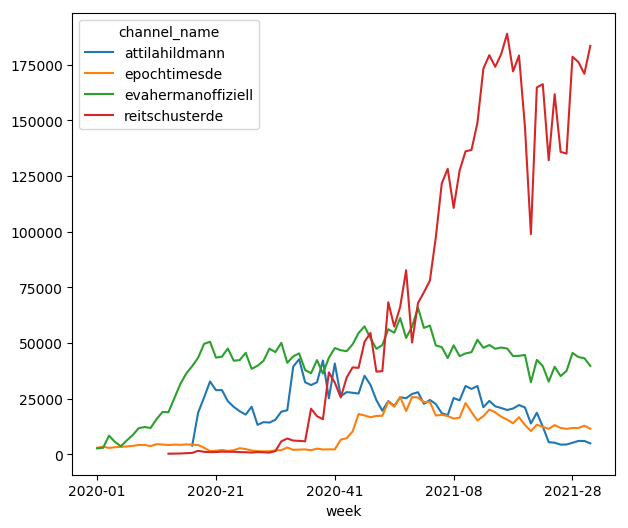

In [60]:
# Averaged view count per message per week for 4 selected channels.

channels_selected = [get_id(channel) for channel in ['reitschusterde', 'attilahildmann', 'epochtimesde', 'evahermanoffiziell']]
df_sub = df_pd[df_pd.channel_id.isin(channels_selected)].assign(week=lambda x: x['datetime'].dt.strftime('%Y-%U'))

evolution_per_channel = df_sub[["channel_id", "week", "views"]].groupby(["week", "channel_id"]).mean().loc["2020-01":"2021-31"]


channel_frequency = (evolution_per_channel
 .reset_index()
 .merge(pairs)
 [["channel_name", "week", "views"]]
 .pivot(index='week', columns='channel_name', values='views')
 .plot
 .line(figsize=(7,6)))



plt.savefig(f'{curr_dir}/data_final/graphics/evolution_views_mean.eps', format='eps', bbox_inches='tight') 

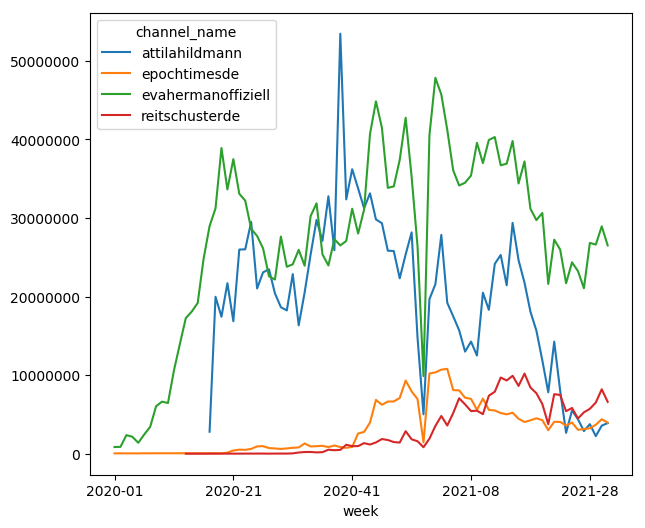

In [61]:
# Accumulated view count of all messages per week for 4 selected channels.
fig, ax = plt.subplots()

evolution_per_channel = df_sub[["channel_id", "week", "views"]].groupby(["week", "channel_id"]).sum().loc["2020-01":"2021-31"]


channel_frequency = (evolution_per_channel
 .reset_index()
 .merge(pairs)
 [["channel_name", "week", "views"]]
 .pivot(index='week', columns='channel_name', values='views')
 .plot
 .line(figsize=(7,6), ax=ax)).ticklabel_format(style='plain', axis='y')


plt.savefig(f'{curr_dir}/data_final/graphics/evolution_views.eps', format='eps', bbox_inches='tight')

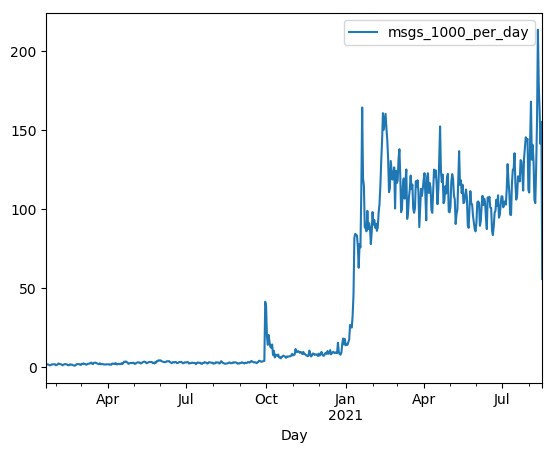

In [62]:
# Englisch channels evolution (not used in thesis, only for understanding)
(df_pd[df_pd.channel_id.isin(list(channels_df.query("language == 'en'").channel_id))]
         .assign(date=lambda x: pd.to_datetime(x['datetime'].dt.date))
         .groupby("date")
         .size()
         .reset_index(name="msgs_per_day")
         .merge(stringency_germany[["Day", "stringency_index"]], left_on="date", right_on="Day", how="inner")
         .assign(msgs_1000_per_day = lambda x: x.msgs_per_day/1000)
         .drop(["date", "msgs_per_day", "stringency_index"], axis=1)
         .set_index("Day")
         .plot())

## 4.6  News Sharing on Telegram

In [63]:
links_de = links[links.channel_id.isin(german_channels)]
german_channel_mask = df_pd.channel_id.isin(german_channels)

print("Shared links total: %s" % len(links_de))
print("Shared links unique: %s" % len(links_de.links.unique()))

Shared links total: 10472998
Shared links unique: 1704951


In [64]:
# Fraction of messages containing at least one link. 
fraction_of_meesages_with_link = len(df_pd[german_channel_mask][df_pd[german_channel_mask].links.apply(len).gt(2)]) / len(df_pd[german_channel_mask])
fraction_of_meesages_with_link

0.29248615082478646

In [65]:
# Fraction of the t.me/* links
fraction_of_links_to_telegram = links_de.domain.value_counts()[0] / links_de.domain.value_counts()[1:].sum()
fraction_of_links_to_telegram

0.31464489485635083

In [66]:
# Clean link data
links.loc[links.domain == "youtu.be", "domain"] = "youtube.com"
links.loc[links.domain == "m.youtube.com", "domain"] = "youtube.com"
links.loc[links.domain == "www.youtube.com", "domain"] = "youtube.com"
links.loc[links.domain == "t.co", "domain"] = "twitter.com"
links.loc[links.domain == 'mobile.twitter.com', "domain"] = "twitter.com"
links.loc[links.domain == "i.4cdn.org", "domain"] = "4chan.org"
links.loc[links.domain == "boards.4chan.org", "domain"] = "4chan.org"
links.loc[links.domain == "m.bild.de", "domain"] = "www.bild.de"
links.loc[links.domain == "uncut-news.ch", "domain"] = "uncutnews.ch"
links.loc[links.domain == 'deutsch.rt.com', "domain"] = 'de.rt.co'

In [67]:
# Annotate data
links_de = links[links.channel_id.isin(german_channels)].set_index("datetime").loc["2020-02-01":].reset_index()

main_domains = list(links_de.domain.value_counts().iloc[1:16].index)

media_type = pd.DataFrame({
    "domain": main_domains, 
    "media_type": ["social_media", "social_media", "alternative", 
                   "established", "alternative", "alternative", "social_media", 
                   "alternative", "alternative", "established", "social_media", "social_media", 
                   "social_media", "established", "social_media"]})


alternative_media = ["www.epochtimes.de", "de.rt.com", "www.journalistenwatch.com", "reitschuster.de", 
                     "uncutnews.ch", "www.wochenblick.at"]

established_media = ["www.bild.de", "www.wochenblick.at", "www.n-tv.de", "www.welt.de"]

social_media = ['youtube.com', 'twitter.com', 'www.bitchute.com', 'odysee.com', 'www.facebook.com', 
                    'telegra.ph', 'load24.me', 'dlive.tv']

media_type

,domain,media_type
0,youtube.com,social_media
1,twitter.com,social_media
2,www.epochtimes.de,alternative
3,www.bild.de,established
4,reitschuster.de,alternative
5,odysee.com,alternative
6,www.bitchute.com,social_media
7,uncutnews.ch,alternative
8,www.welt.de,alternative
9,de.rt.com,established


In [68]:
media = None

In [69]:
# Link shorteners 
domain_count = links_de.groupby("domain").size()
sum_links = domain_count.sum()
bitly_count = domain_count.reset_index(name="count").query("domain=='bit.ly'")["count"].iloc[0]
percentage_bitly = bitly_count / sum_links
percentage_bitly

0.007036147494166444

In [70]:
# Top 20 sites with media_type and shared count
def get_media_type(site):
    if site in alternative_media:
        return "Alternative media"
    if site in established_media:
        return "Established media"
    if site in social_media:
        return "Social media"
    else: 
        return "other"
    
top_20 = domain_count.sort_values(ascending=False).reset_index(name="count").iloc[1:21, :]

top_20_w_media = top_20.assign(media_type=lambda x: [get_media_type(site) for site in x.domain])
top_20_w_media

,domain,count,media_type
1,youtube.com,1629280,Social media
2,twitter.com,402986,Social media
3,www.epochtimes.de,163221,Alternative media
4,www.bild.de,162148,Established media
5,reitschuster.de,91493,Alternative media
6,odysee.com,90198,Social media
7,www.bitchute.com,88247,Social media
8,uncutnews.ch,87276,Alternative media
9,www.welt.de,86516,Established media
10,de.rt.com,84729,Alternative media


In [71]:
# Shares of channels by category 
top_20_w_media.media_type.value_counts().apply(lambda x: x/20)

Social media         0.40
Alternative media    0.30
other                0.15
Established media    0.15
Name: media_type, dtype: float64

### 4.6.1  Social Media

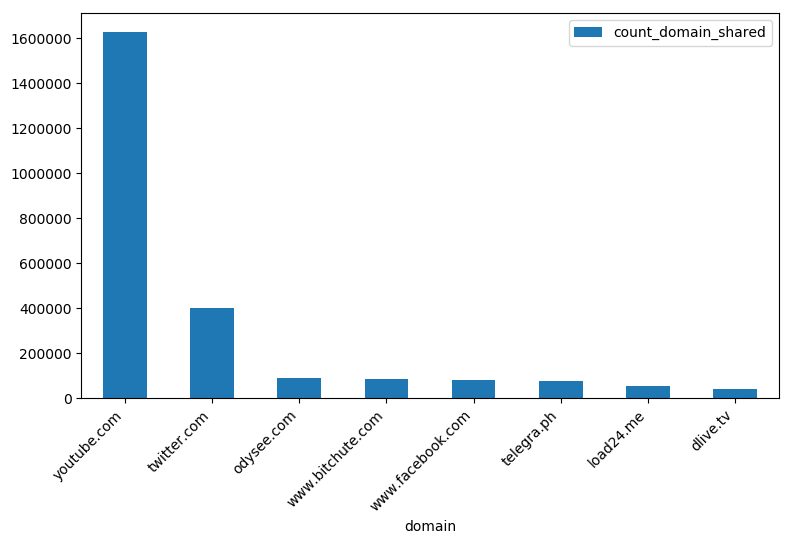

In [72]:
# Most shared social media sites in German Telegram channels
links_top_20 = links_de[links_de.domain.isin(list(top_20.domain))].assign(media_type=lambda x: [get_media_type(site) for site in x.domain])

fig, ax = plt.subplots(figsize=(9,5))

amount_of_shares = (links_top_20[links_top_20.domain.isin(social_media)]
 .groupby(["domain", "media_type"])
 .size()
 .reset_index(name="count_domain_shared")
 .sort_values(by="count_domain_shared", ascending=False)
 .set_index("domain"))

(amount_of_shares.plot
 .bar(y="count_domain_shared",
      ax=ax))

x_dates = amount_of_shares.index.unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

None

plt.savefig(f'{curr_dir}/data_final/graphics/links_to_social_media.eps', format='eps', bbox_inches='tight')

### 4.6.2  Media outlets

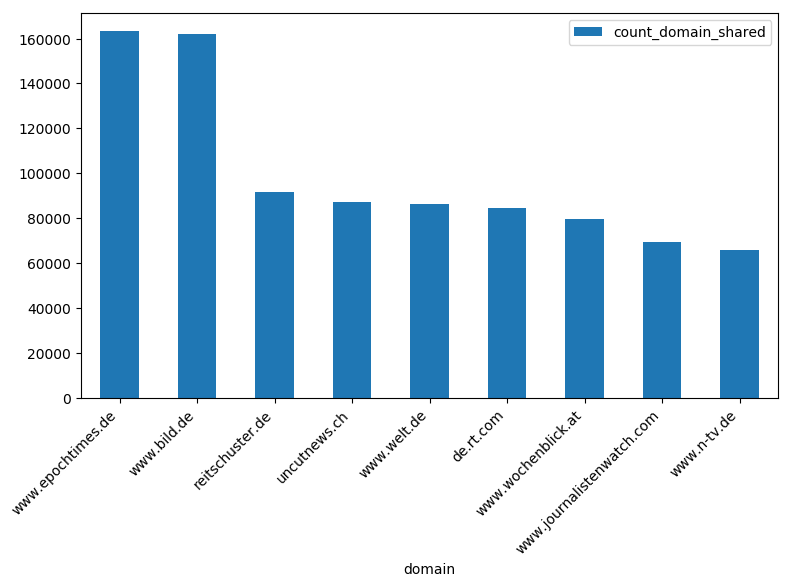

In [73]:
# Most shared news sites in German Telegram channels
fig, ax = plt.subplots(figsize=(9,5))

amount_of_shares = (links_top_20[links_top_20.domain.isin(np.append(established_media, alternative_media))]
 .groupby(["domain", "media_type"])
 .size()
 .reset_index(name="count_domain_shared")
 .sort_values(by="count_domain_shared", ascending=False)
 .set_index("domain"))

(amount_of_shares.plot
 .bar(y="count_domain_shared",
      ax=ax))

x_dates = amount_of_shares.index.unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

None


plt.savefig(f'{curr_dir}/data_final/graphics/links_to_media.eps', format='eps', bbox_inches='tight')

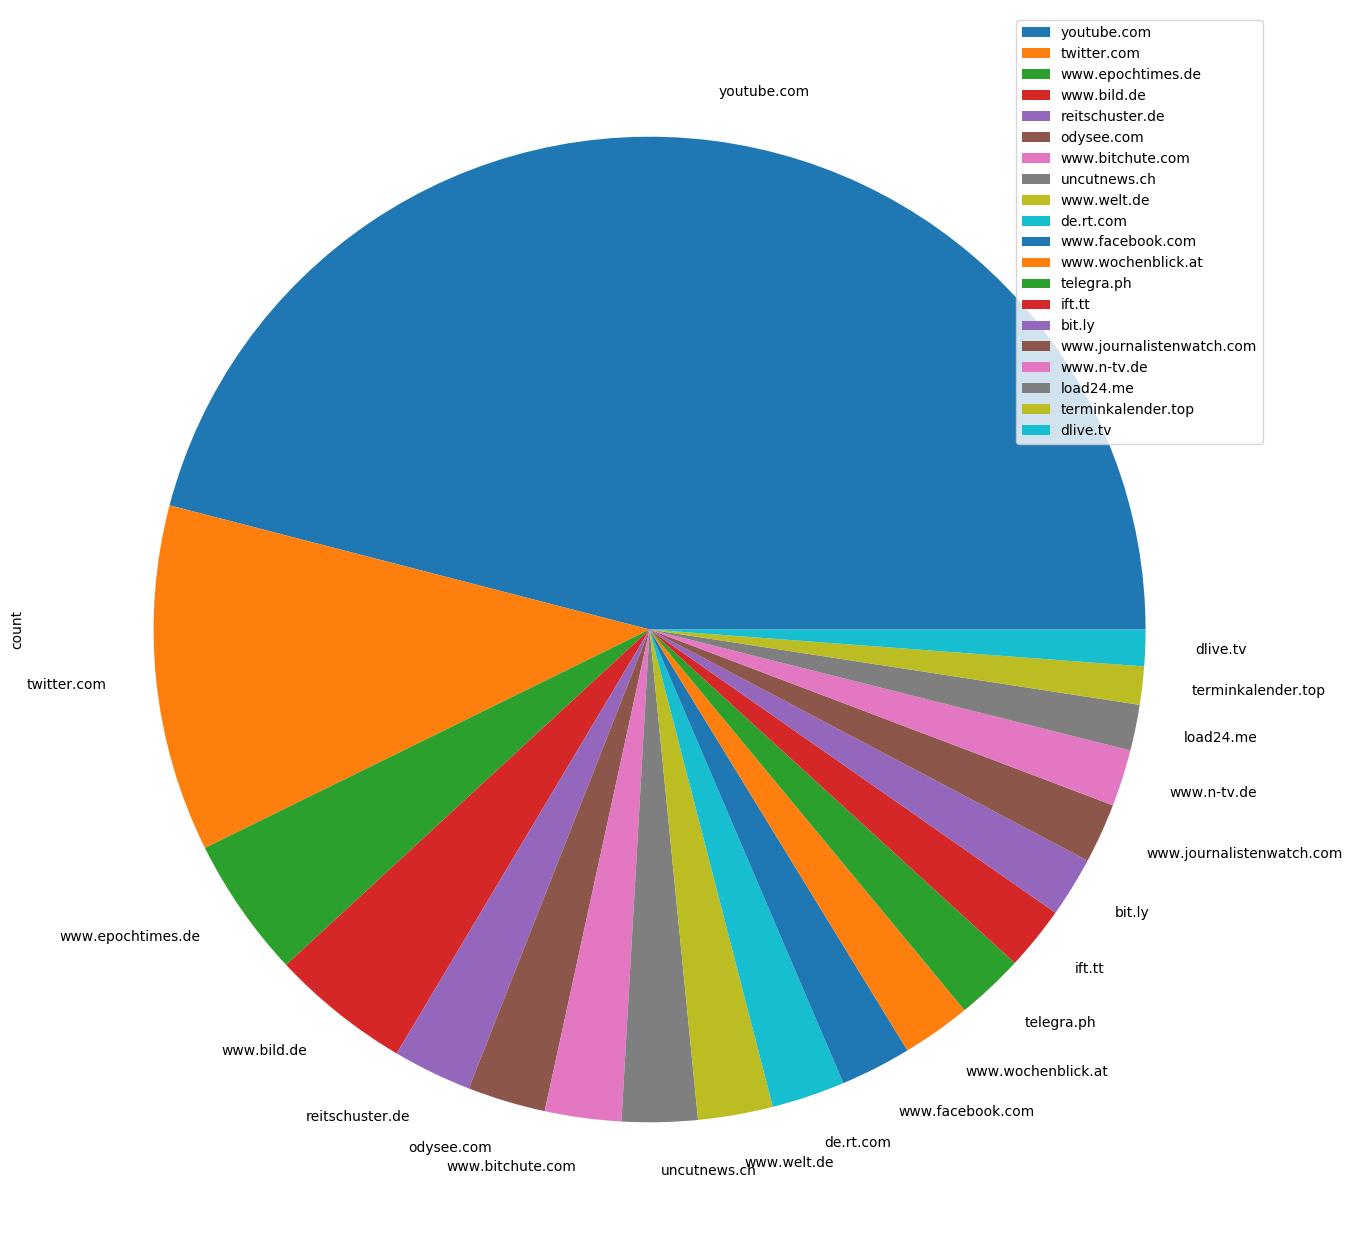

In [74]:
fig, ax = plt.subplots(figsize=(16,16))

top_20.set_index("domain").plot.pie(y="count", ax=ax)

/opt/conda/lib/python3.7/site-packages/matplotlib/axes/_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


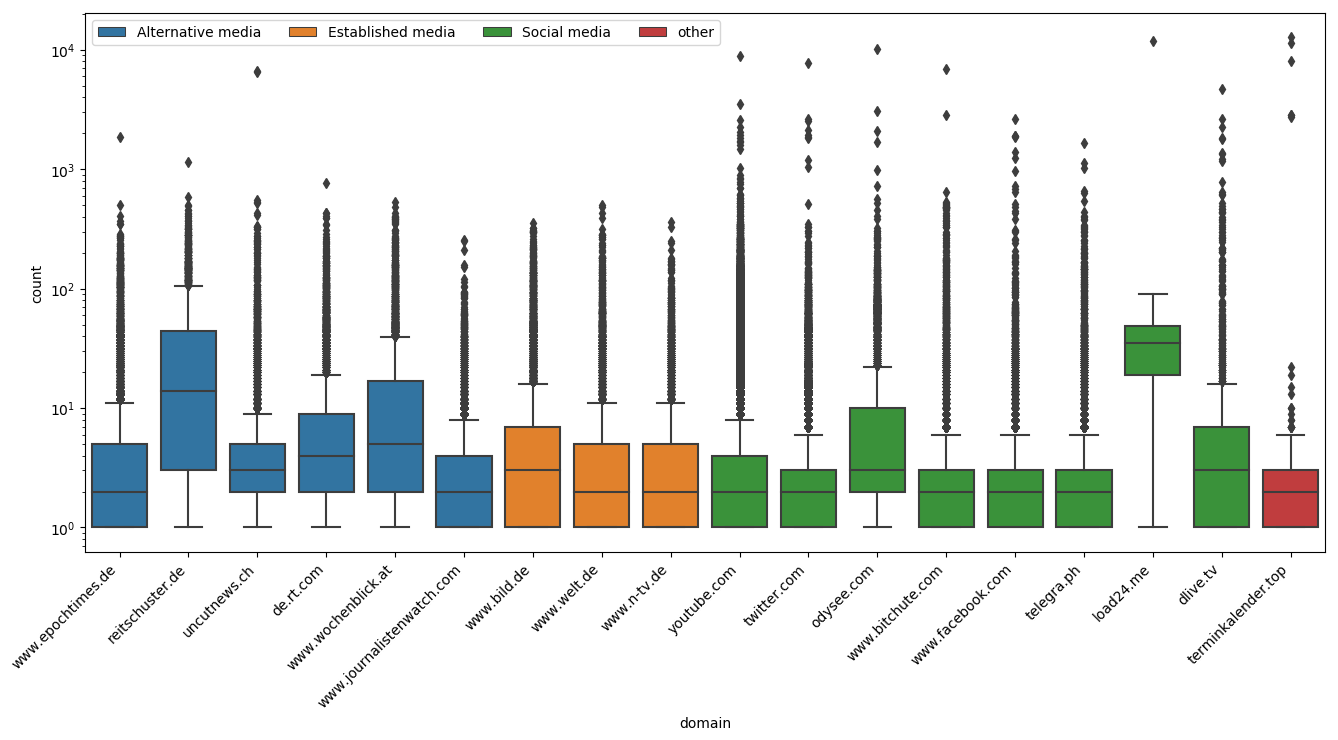

In [75]:
# Distribution over how many times each link from a website was shared. 
# Websites ordered by media type and total amount of shares.
amount_of_shares = (links_top_20
 .groupby(["domain", "media_type"])
 .size()
 .reset_index(name="count_domain_shared")
[["domain", "count_domain_shared"]])

count_domain_shared = (links_top_20
 .groupby(["domain", "links", "media_type"])
 .size()
 .reset_index(name="count")
 .merge(amount_of_shares)
 .sort_values(by=["media_type", "count_domain_shared"], ascending=[True, False])
 .query("domain != 'bit.ly'")
 .query("domain != 'ift.tt'"))


fig, ax = plt.subplots(figsize=(16,7))

ax.set(yscale="log")
g = sns.boxplot(x="domain", y="count", data=count_domain_shared, ax=ax, dodge=False, hue="media_type")
x_dates = count_domain_shared.domain.unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
#plt.legend([],[], frameon=False)
plt.legend(loc='upper left', ncol=4)

None

plt.savefig(f'{curr_dir}/data_final/graphics/boxplot_media.eps', format='eps', bbox_inches='tight')

# Discussion 

## 5.1  The unknown recommendation problem

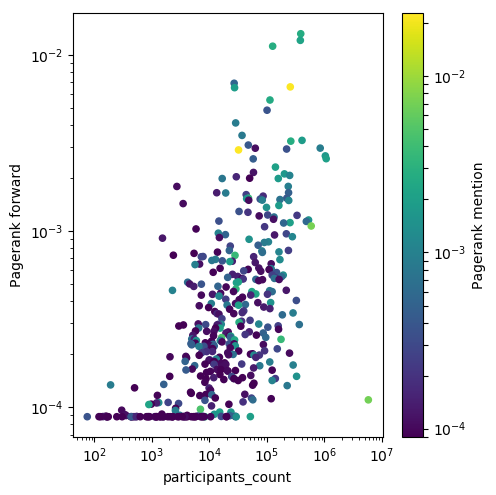

In [76]:
# Scatterplot between the Pagerank and participants count per channel. (only english)
(merged_meta[merged_meta.language == "en"]
 .rename(columns={"pagerank": "Pagerank forward", "pagerank_mention": "Pagerank mention"})
 .plot
 .scatter(x='participants_count',
            y="Pagerank forward",
            logy=True, 
            logx=True,
            figsize=(5, 5.5),
            c='Pagerank mention',
            colormap='viridis',
            norm=matplotlib.colors.LogNorm()))

plt.savefig(f'{curr_dir}/data_final/graphics/pagerank_scatter_english.eps', format='eps', bbox_inches='tight')    

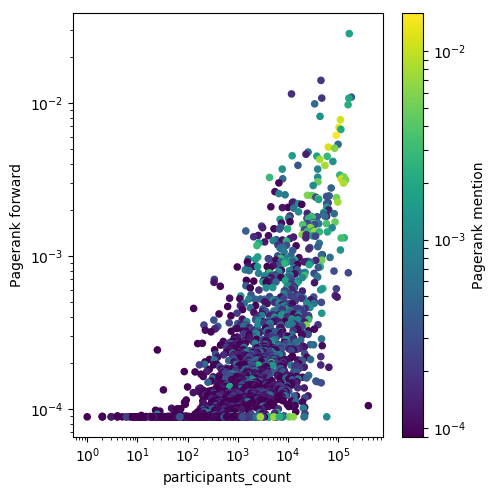

In [77]:
# Scatterplot between the Pagerank and participants count per channel. (only german)
(merged_meta[merged_meta.language == "de"]
 .rename(columns={"pagerank": "Pagerank forward", "pagerank_mention": "Pagerank mention"})
 .plot
 .scatter(x='participants_count',               
            y='Pagerank forward',
            logy=True,                                                                         
            logx=True,
            figsize=(5, 5.5),
            c="Pagerank mention",
            colormap='viridis',
            norm=matplotlib.colors.LogNorm()))
 
plt.savefig(f'{curr_dir}/data_final/graphics/pagerank_scatter_german.eps', 
            format='eps', 
            bbox_inches='tight')  

## 5.2  Sampling bias and scraping

In [78]:
reitschuter_chat_id = get_id("reitschusterdechat")
reitschuter_chat_len = len(df_pd.query("channel_id == @reitschuter_chat_id").set_index("datetime").loc["2021-08-08":"2021-08-15"])

q_family_id = get_id('donald_j_trump_q_family_germany')
q_family_len = len(df_pd.query("channel_id == @q_family_id").set_index("datetime").loc["2021-08-08":"2021-08-15"])

print(f'Messages in the second week of August 2021 in reitschusterdechat: {reitschuter_chat_len} and the biggest german group donald_j_trump_q_family_germany: {q_family_len}')

Messages in the second week of August 2021 in reitschusterdechat: 48130 and the biggest german group donald_j_trump_q_family_germany: 41578


# Conclusion

In [79]:
# Biggest channels
(df_pd
 .set_index("datetime")
 .loc["2021-08-08":"2021-08-15"]
 .groupby("channel_id")
 .size()
 .sort_values(ascending=False)
 .reset_index(name="count")
 .merge(channels_df)
 [["channel_name", "count", "language"]]
 .head(10))

,channel_name,count,language
0,codemonkeyzchat,140522,en
1,disclosetv_chat,70618,en
2,wethemediachat,69494,en
3,therealkimshady1,57837,en
4,reitschusterdechat,48130,de
5,tommy_robinson_chat,42612,en
6,donald_j_trump_q_family_germany,41578,de
7,savagedog25ive,40023,en
8,richardcitizenjournalistopenchat,38228,en
9,awakeningglobal,37007,en


In [80]:
# Amount of unique invite links to private chats 
private_chats_unique = links_de[["links"]][links_de.links.str.match('https://t.me/joinchat/*')].links.unique()
len(private_chats_unique)

7897